<h1>¿Qué correlaciones hay en los indicadores de operacion y servicio en la entrega de concreto?</h1>

In [69]:
import modulo_conn_sql as mcq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Query BD SQL-Server Cemex
def querySQL(query, parametros):
    #Conectar con base sql y ejecutar consulta
    cursor = conectarSQL()
    try:
        cursor.execute(query, parametros)
        #obtener nombre de columnas
        names = [ x[0] for x in cursor.description]
        
        #Reunir todos los resultado en rows
        rows = cursor.fetchall()
        resultadoSQL = []
            
        #Hacer un array con los resultados
        while rows:
            resultadoSQL.append(rows)
            if cursor.nextset():
                rows = cursor.fetchall()
            else:
                rows = None
                
        #Redimensionar el array para que quede en dos dimensiones
        resultadoSQL = np.array(resultadoSQL)
        resultadoSQL = np.reshape(resultadoSQL, (resultadoSQL.shape[1], resultadoSQL.shape[2]) )
    finally:
            if cursor is not None:
                cursor.close()
    return pd.DataFrame(resultadoSQL, columns = names)

#SQL Methods to get operation data
def conectarSQL():
    conn = mcq.ConexionSQL()
    cursor = conn.getCursor()
    return cursor

In [15]:
#parametros
pais = 'Colombia'
fechainicio = '2021-10-01'
fechafin = '2021-10-31'

#Dataframe con los despachos
df_despacho = querySQL( "{CALL SCAC_AP10_dataset_servicios_rango (?,?,?)}" , (pais, fechainicio, fechafin) )
df_despacho['Entrega'] = df_despacho['Entrega'].str.strip()
df_despacho['VolPartida'] = pd.to_numeric(df_despacho['VolPartida'])
df_despacho['TiempoCargue'] = pd.to_numeric(df_despacho['TiempoCargue'])
df_despacho['DistanciaPlantaObraKm'] = pd.to_numeric(df_despacho['DistanciaPlantaObraKm'])
df_despacho['TiempoObra'] = pd.to_numeric(df_despacho['TiempoObra'])

#eliminacion de plantas CXO
df_despacho = df_despacho[df_despacho['TipoPlanta'] == 'Central'] 

In [92]:
#edad del volumen
edad = querySQL( "{CALL SCAC_AP13_EdadVolumen (?,?,?)}" , (pais, '2021-10-01', '2021-10-31') )
#edad = pd.read_excel("datos/" + pais +"/" + pais +" EdadVolumen.xlsx")
edad['Fecha'] = pd.to_datetime(edad['Fecha'])
edad['Obra'] = edad['Obra'].astype(str)
edad['year_month'] = edad.Fecha.dt.to_period('M')
edad['Edad'] = pd.to_datetime(edad['Fecha']) - pd.to_datetime(edad['PrimerConsumo'])
edad['Edad'] = edad['Edad'] / np.timedelta64(1,'D')

In [93]:
analisis_edad = edad[~edad['Obra'].str.contains('F')].groupby(['year_month','Obra']).agg({'Edad':'max', 'Vol':'sum'}).reset_index()
analisis_edad['volumen_nuevo'] = analisis_edad['Vol'].where(analisis_edad['Edad'] <= 30 , 0)

In [94]:
analisis_edad

,year_month,Obra,Edad,Vol,volumen_nuevo
0,2021-10,65278858,3147.0,9.25,0.00
1,2021-10,65283399,3122.0,14.00,0.00
2,2021-10,65440211,1859.0,58.00,0.00
3,2021-10,65718508,2754.0,48.50,0.00
4,2021-10,65784521,2701.0,20.00,0.00
...,...,...,...,...,...
781,2021-10,67014363,0.0,14.00,14.00
782,2021-10,67014366,0.0,12.00,12.00
783,2021-10,67014516,0.0,42.50,42.50
784,2021-10,67014560,0.0,7.75,7.75


In [57]:
df_despacho.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17258 entries, 0 to 18171
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Pedido                 17258 non-null  object        
 1   servicio               17258 non-null  object        
 2   Entrega                17258 non-null  object        
 3   Estatus                17258 non-null  object        
 4   EstatusPedido          17258 non-null  object        
 5   Cluster                17258 non-null  object        
 6   Planta                 17258 non-null  object        
 7   TipoPlanta             17258 non-null  object        
 8   Ciudad                 17258 non-null  object        
 9   Centro                 17258 non-null  object        
 10  NombreObra             17258 non-null  object        
 11  Obra                   17258 non-null  object        
 12  NombreCliente          17258 non-null  object        
 13  C

In [58]:
df_despacho.head(5).T

,0,1,2,3,4
Pedido,8011860687,8011836540-P,8011836540-P,8011836540-P,8011836540-P
servicio,L001,L001,L002,L003,L004
Entrega,202349712,202137051,202156422,202157569,202168755
Estatus,Normal,Normal,Normal,Normal,Normal
EstatusPedido,Completada - Cabecera,En proceso - Cabecera,En proceso - Cabecera,En proceso - Cabecera,En proceso - Cabecera
Cluster,CLUSTER CENTRO,CLUSTER CENTRO,CLUSTER CENTRO,CLUSTER CENTRO,CLUSTER CENTRO
Planta,CO-PLANTA SUR (DTE),CO-PLANTA SUR (DTE),CO-PLANTA SUR (DTE),CO-PLANTA SUR (DTE),CO-PLANTA SUR (DTE)
TipoPlanta,Central,Central,Central,Central,Central
Ciudad,Bogotá,Bogotá,Bogotá,Bogotá,Bogotá
Centro,F006,F006,F006,F006,F006


In [ ]:
#volumen por centro
df_volumen = df_despacho.groupby(['Centro', 'FechaEntrega']).agg({'VolPartida':'sum'}).reset_index()


#m3 / hora -> capacidad instantanea
#filtro los datos de tiempo de cargue, para filtar atipicos
df_capacidad_instantanea = df_despacho[(df_despacho['TiempoCargue'] > 2) & (df_despacho['TiempoCargue'] < 30)]
df_capacidad_instantanea['df_m3_min'] = df_capacidad_instantanea['VolPartida'] / df_capacidad_instantanea['TiempoCargue']
df_capacidad_instantanea = df_capacidad_instantanea.groupby(['Centro', 'FechaEntrega']).agg({'df_m3_min': 'median'}).reset_index()
df_capacidad_instantanea ['capacidad_instantanea'] = df_capacidad_instantanea['df_m3_min'] * 60
df_capacidad_instantanea = df_capacidad_instantanea[['Centro', 'FechaEntrega','capacidad_instantanea']]

#productividad mixer
df_productividad = df_despacho[(~df_despacho['Placa'].str.contains('RMS'))&(df_despacho['Placa'] != '') ]
df_productividad = df_productividad.groupby(['Centro','FechaEntrega']).agg({'VolPartida':'sum', 'Placa':'nunique'}).reset_index()
df_productividad['productividad_mx'] = df_productividad['VolPartida'] / df_productividad['Placa']
df_productividad = df_productividad[['Centro','FechaEntrega','productividad_mx']]

#kilometros por metro cubico
df_km_m3 = df_despacho[df_despacho['VolPartida'] > 0]
df_km_m3['km_m3'] = (df_km_m3['DistanciaPlantaObraKm'] * 2) / df_km_m3['VolPartida']
df_km_m3 = df_km_m3.groupby(['Centro','FechaEntrega']).agg({'km_m3':'mean'}).reset_index()


#cumplimiento
df_cumpto = df_despacho.groupby(['Centro','FechaEntrega']).agg({'Cumplimiento':'sum', 'Entrega':'count'}).reset_index()
df_cumpto['cumpto'] = df_cumpto['Cumplimiento'] / df_cumpto['Entrega']
df_cumpto = df_cumpto[['Centro','FechaEntrega','cumpto']]

#tiempo en obra
df_tiempo_obra = df_despacho.groupby(['Centro', 'FechaEntrega']).agg({'TiempoObra':'mean'}).reset_index()


In [86]:
df_tiempo_obra

,Centro,FechaEntrega,TiempoObra
0,F001,2021-10-01,45.209302
1,F001,2021-10-02,50.294118
2,F001,2021-10-04,60.787234
3,F001,2021-10-05,49.651163
4,F001,2021-10-06,66.212766
...,...,...,...
526,FB40,2021-10-21,NaN
527,FB40,2021-10-22,30.285714
528,FB40,2021-10-23,82.833333
529,FB40,2021-10-25,46.461538


In [87]:
df = df_volumen.copy()
df = pd.merge(df, df_capacidad_instantanea, on = ['Centro', 'FechaEntrega'])
df = pd.merge(df, df_productividad, on = ['Centro', 'FechaEntrega'])
df = pd.merge(df, df_km_m3, on = ['Centro', 'FechaEntrega'])
df = pd.merge(df, df_cumpto, on = ['Centro', 'FechaEntrega'])
df = pd.merge(df, df_tiempo_obra, on = ['Centro', 'FechaEntrega'])

In [88]:
df

,Centro,FechaEntrega,VolPartida,capacidad_instantanea,productividad_mx,km_m3,Cumplimiento,Entrega,cumpto,TiempoObra
0,F001,2021-10-01,309.00,75.000000,16.263158,4.936575,50,51,0.980392,45.209302
1,F001,2021-10-02,322.50,69.500000,17.916667,3.820581,39,42,0.928571,50.294118
2,F001,2021-10-04,427.00,72.857143,23.722222,3.953777,53,58,0.913793,60.787234
3,F001,2021-10-05,383.75,75.000000,20.197368,4.407537,46,54,0.851852,49.651163
4,F001,2021-10-06,411.00,70.000000,20.550000,4.334721,55,57,0.964912,66.212766
...,...,...,...,...,...,...,...,...,...,...
526,FB40,2021-10-21,16.45,42.000000,5.483333,7.265184,3,3,1.000000,NaN
527,FB40,2021-10-22,114.50,38.181818,12.722222,5.423068,16,17,0.941176,30.285714
528,FB40,2021-10-23,106.00,38.214286,9.636364,2.777805,14,14,1.000000,82.833333
529,FB40,2021-10-25,151.75,42.857143,7.226190,8.938655,15,26,0.576923,46.461538


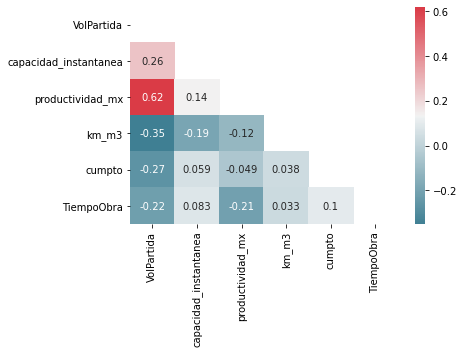

In [91]:
df_corr = df[['VolPartida','capacidad_instantanea','productividad_mx','km_m3','cumpto','TiempoObra']]
corrMatrix = df_corr.corr()
sns.heatmap(
    corrMatrix, 
    annot=True, 
    cmap = sns.diverging_palette(220, 10, as_cmap=True), 
    mask = np.triu(np.ones_like(corrMatrix, dtype=bool)) )
plt.show()

C:\Users\JSDELGADOC\Anaconda3\lib\site-packages\seaborn\matrix.py:204: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\JSDELGADOC\Anaconda3\lib\site-packages\seaborn\matrix.py:209: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


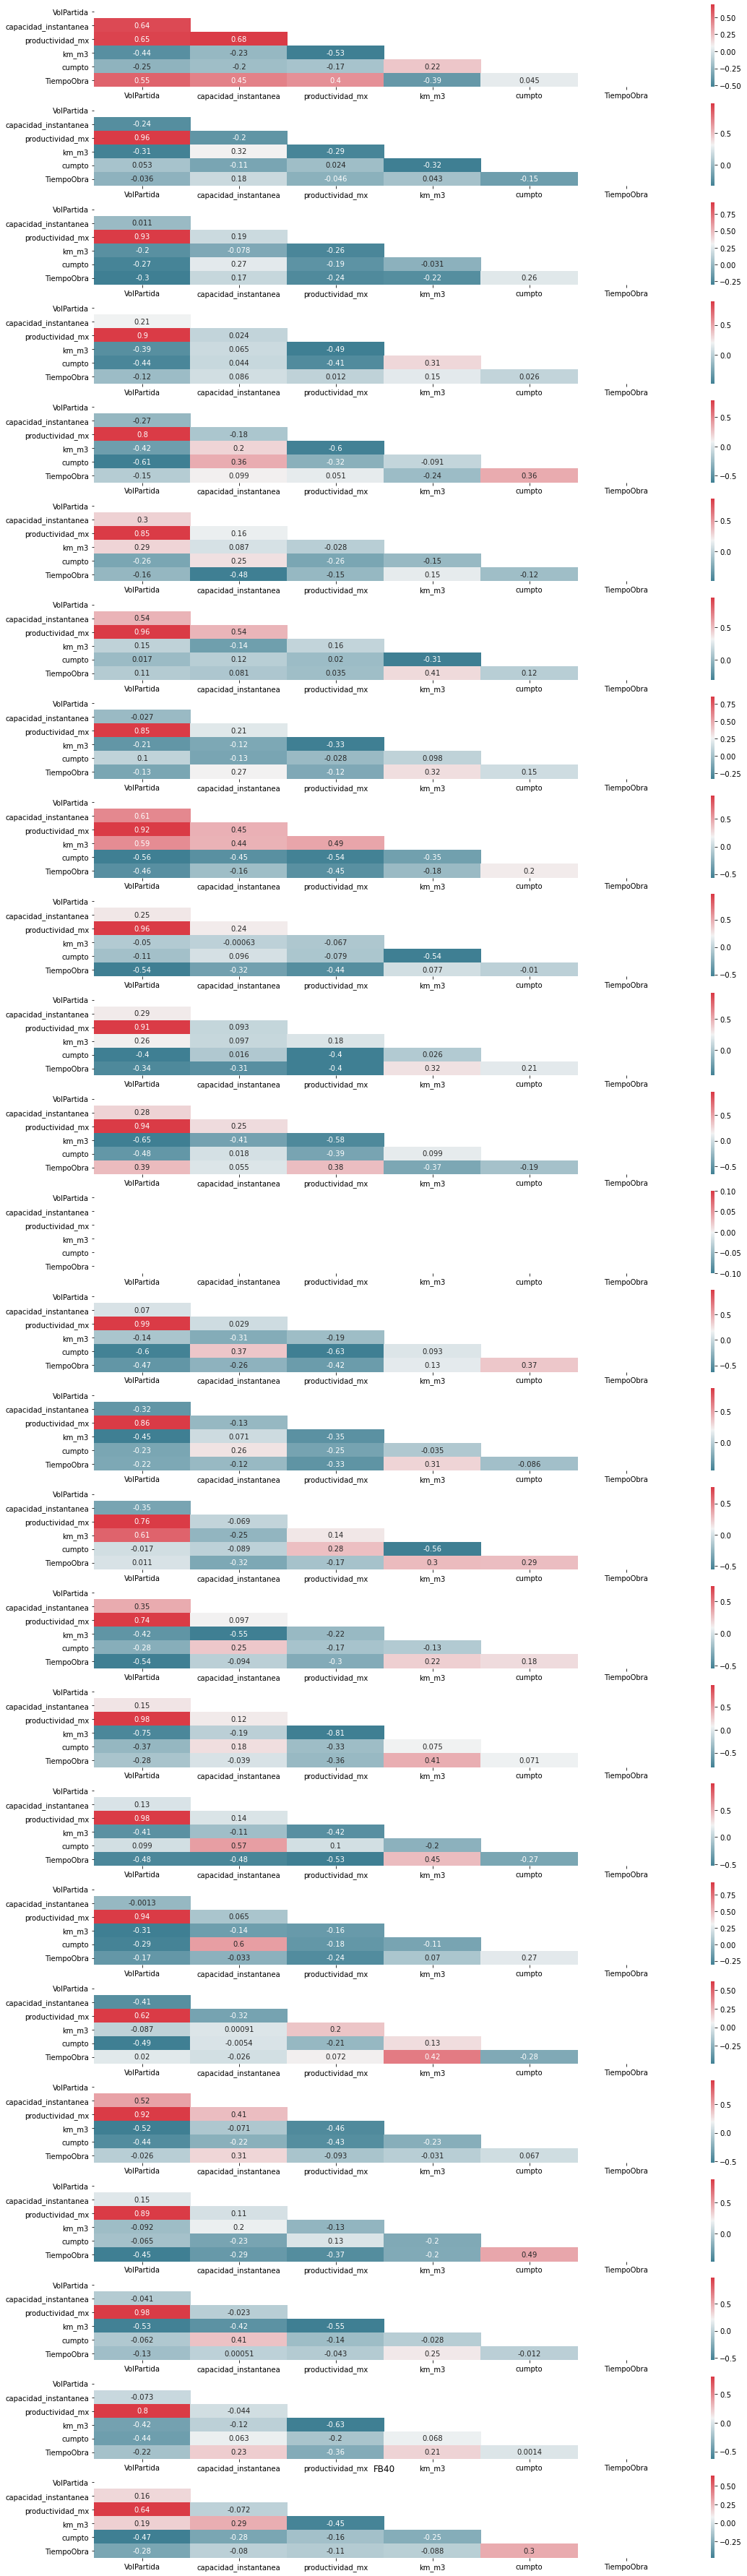

In [95]:
plantas = df_despacho['Centro'].unique()
fig, ax= plt.subplots(len(plantas), 1, figsize=(18,65))
#plt.figure(figsize=(18,50))
for i,var in enumerate(plantas):
    df_corr = df[df['Centro'] == var]
    df_corr = df_corr[['VolPartida','capacidad_instantanea','productividad_mx','km_m3','cumpto','TiempoObra']]
    corrMatrix = df_corr.corr()
    sns.heatmap(
        corrMatrix, 
        annot=True, 
        cmap = sns.diverging_palette(220, 10, as_cmap=True), 
        mask = np.triu(np.ones_like(corrMatrix, dtype=bool)),
        ax = ax[i])

    plt.title(var)